In [24]:
pip install conllu

In [3]:
import conllu
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import spacy
from wordcloud import WordCloud
from scipy.stats import chi2_contingency
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
with open("en_gum-ud-train.conllu", "r", encoding="utf-8") as f:
    data = f.read()
sentences = conllu.parse(data)

In [5]:
nlp = spacy.load("en_core_web_sm")

In [45]:
def basic_stats(sentences):
    stats = {
        'n_sentences': len(sentences),
        'n_tokens': sum(len(sent) for sent in sentences),
        'avg_tokens_per_sent': round(sum(len(sent) for sent in sentences)/len(sentences), 2),
        'unique_lemmas': len(set(token['lemma'].lower() for sent in sentences for token in sent if token['lemma']))
    }
    return stats

In [7]:
stats = basic_stats(sentences)
print("Statistiques générales:")
for k, v in stats.items():
    print(f"- {k}: {v}")

Statistiques générales:
- n_sentences: 9520
- n_tokens: 166918
- avg_tokens_per_sent: 17.53
- unique_lemmas: 11972


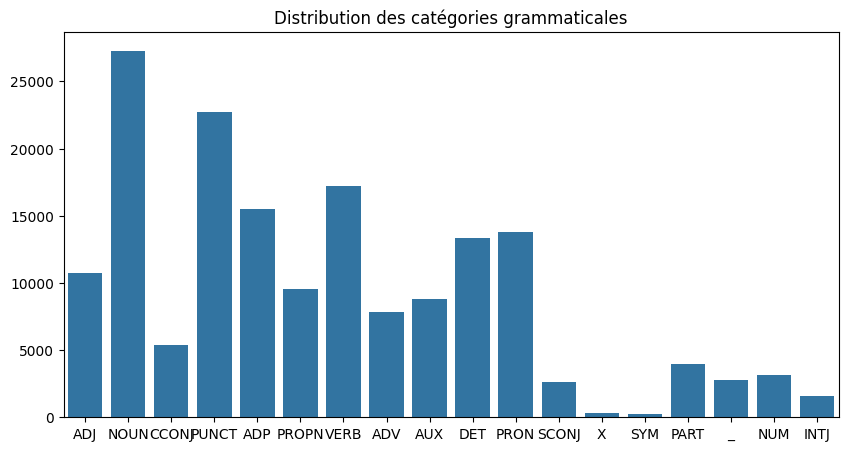

In [44]:
pos_counter = Counter(token['upostag'] for sent in sentences for token in sent)
plt.figure(figsize=(10,5))
sns.barplot(x=list(pos_counter.keys()), y=list(pos_counter.values()))
plt.title('Distribution des catégories grammaticales')
plt.show()


<ipython-input-42-161dcee6878d>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[v[1] for v in lemma_counter],


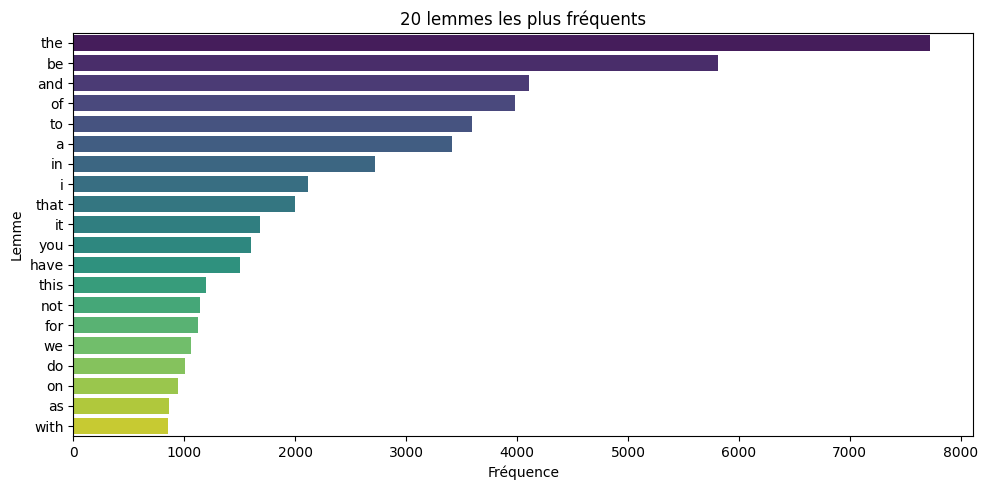

In [42]:
lemmas = [token['lemma'].lower()
          for sent in sentences
          for token in sent
          if token['upostag'] not in ['PUNCT', 'SYM']
          and token['lemma'] != '_']

lemma_counter = Counter(lemmas).most_common(20)

plt.figure(figsize=(10,5))
sns.barplot(x=[v[1] for v in lemma_counter],
            y=[v[0] for v in lemma_counter],
            palette="viridis")
plt.title('20 lemmes les plus fréquents')
plt.xlabel('Fréquence')
plt.ylabel('Lemme')
plt.tight_layout()
plt.show()

In [10]:
def analyze_morph(sentences):
    tense = Counter()
    gender = Counter()
    for sent in sentences:
        for token in sent:
            feats = token['feats']
            if feats:
                if 'Tense' in feats:
                    tense[feats['Tense']] += 1
                if 'Gender' in feats:
                    gender[feats['Gender']] += 1
    return tense, gender

In [11]:
tense, gender = analyze_morph(sentences)
print("\nTemps verbaux:", tense)
print("Genres grammaticaux:", gender)


Temps verbaux: Counter({'Pres': 9769, 'Past': 7412})
Genres grammaticaux: Counter({'Neut': 1884, 'Masc': 1121, 'Fem': 624, 'Fem,Masc': 3})


#Analyse Syntaxique


In [12]:
deprel_counter = Counter(token['deprel'] for sent in sentences for token in sent)
print("\nTop relations de dépendance:", deprel_counter.most_common(10))



Top relations de dépendance: [('punct', 22748), ('case', 15016), ('det', 12847), ('nsubj', 11953), ('root', 9520), ('amod', 8502), ('advmod', 8201), ('obj', 7303), ('obl', 7268), ('nmod', 6342)]


In [13]:
def get_pos_ngrams(sentences, n=3):
    ngrams = Counter()
    for sent in sentences:
        pos = [token['upostag'] for token in sent]
        for i in range(len(pos)-n+1):
            ngrams[tuple(pos[i:i+n])] += 1
    return ngrams

In [14]:
pos_trigrams = get_pos_ngrams(sentences).most_common(10)
print("\nStructures syntaxiques fréquentes (POS trigrammes):", pos_trigrams)



Structures syntaxiques fréquentes (POS trigrammes): [(('ADP', 'DET', 'NOUN'), 3189), (('DET', 'ADJ', 'NOUN'), 2417), (('NOUN', 'ADP', 'DET'), 2280), (('DET', 'NOUN', 'ADP'), 2265), (('ADJ', 'NOUN', 'PUNCT'), 2167), (('DET', 'NOUN', 'PUNCT'), 1956), (('VERB', 'DET', 'NOUN'), 1812), (('NOUN', 'ADP', 'NOUN'), 1605), (('ADJ', 'NOUN', 'ADP'), 1493), (('_', 'PRON', 'AUX'), 1411)]


In [17]:
dep_length_list = [
    abs(token["head"] - i)
    for sent in sentences
    for i, token in enumerate(sent)
    if token.get("head") is not None and isinstance(token["head"], int) and token["head"] > 0
]
print(f"\nLongueur moyenne des dépendances: {sum(dep_length_list)/len(dep_length_list):.2f}")




Longueur moyenne des dépendances: 3.58


In [18]:
roots = [token['lemma'] for sent in sentences for token in sent if token['deprel'] == 'root']
print("\nVerbes racines fréquents:", Counter(roots).most_common(10))


Verbes racines fréquents: [('have', 288), ('be', 227), ('say', 192), ('know', 143), ('think', 140), ('get', 137), ('go', 135), ('make', 116), ('take', 100), ('do', 92)]


##Analyse Discursive

In [19]:
connecteurs = {'however', 'therefore', 'moreover', 'because', 'although', 'thus', 'nevertheless'}
connectors_genre = defaultdict(Counter)
for sent in sentences:
    genre = sent.metadata.get('genre', 'inconnu')
    for token in sent:
        if token['lemma'].lower() in connecteurs:
            connectors_genre[genre][token['lemma']] += 1


In [20]:
genres = list(connectors_genre.keys())
data = [list(connectors_genre[g].values()) for g in genres]
chi2, p, _, _ = chi2_contingency(data)
print(f"\nSignificativité des différences entre genres (connecteurs): p={p:.4f}")


Significativité des différences entre genres (connecteurs): p=1.0000


##Comparaisons entre Genres

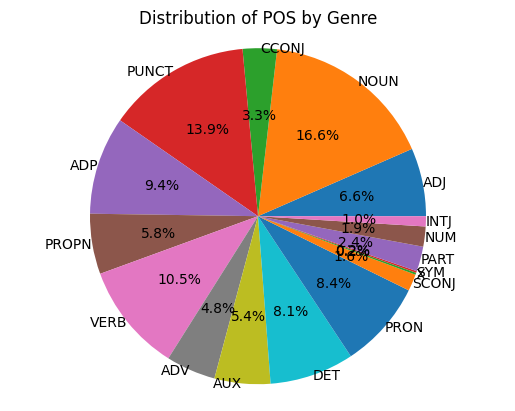

In [39]:
from pickle import NONE
pos_genre = defaultdict(lambda: defaultdict(int))
for sent in sentences:
    genre = sent.metadata.get('genre', 'inconnu')
    for token in sent:
        pos_genre[genre][token['upostag']] += 1

# Data preparation for pie chart
genre_pos_counts = defaultdict(int)
for genre, pos_counts in pos_genre.items():
    for pos, count in pos_counts.items():
        genre_pos_counts[(genre, pos)] += count

# Creating the pie chart
# Filter out labels containing '_'
labels = [f"{pos}" for genre, pos in genre_pos_counts.keys() if pos != '_']
sizes = [value for (genre, pos), value in genre_pos_counts.items() if pos != '_']

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%',labeldistance=1)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Distribution of POS by Genre')
plt.show()

In [31]:
print(labels)

['ADJ', 'NOUN', 'CCONJ', 'PUNCT', 'ADP', 'PROPN', 'VERB', 'ADV', 'AUX', 'DET', 'PRON', 'SCONJ', 'X', 'SYM', 'PART', '_', 'NUM', 'INTJ']


##Visualisations

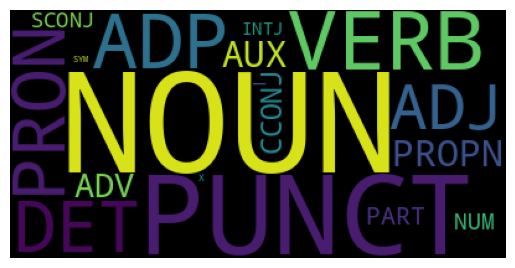

In [22]:
pos_cloud = WordCloud().generate_from_frequencies(pos_counter)
plt.imshow(pos_cloud)
plt.axis('off')
plt.show()


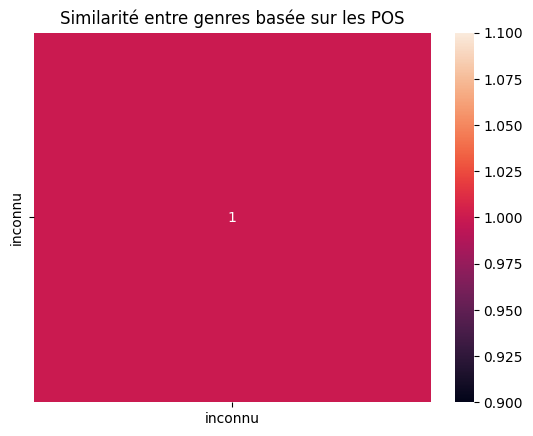

In [43]:
doc = nlp(" ".join([token['form'] for token in sentences[0]]))
spacy.displacy.render(doc, style='dep', options={'compact': True}, jupyter=False)

# E18. Similarité entre genres
similarity = cosine_similarity(df_pos.T)
sns.heatmap(similarity, annot=True, xticklabels=genres, yticklabels=genres)
plt.title('Similarité entre genres basée sur les POS')
plt.show()

##NER


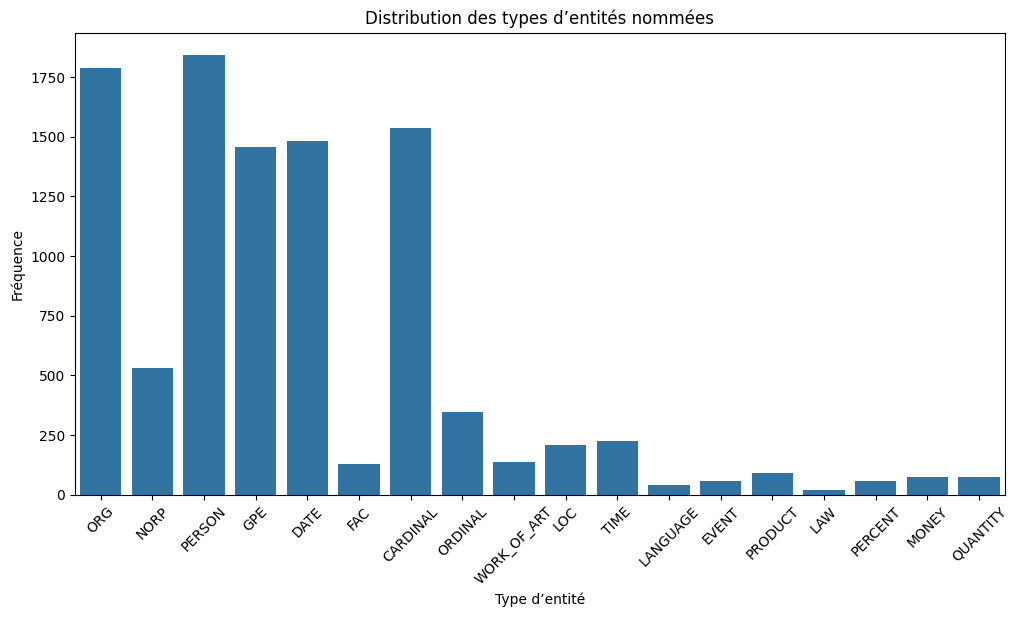

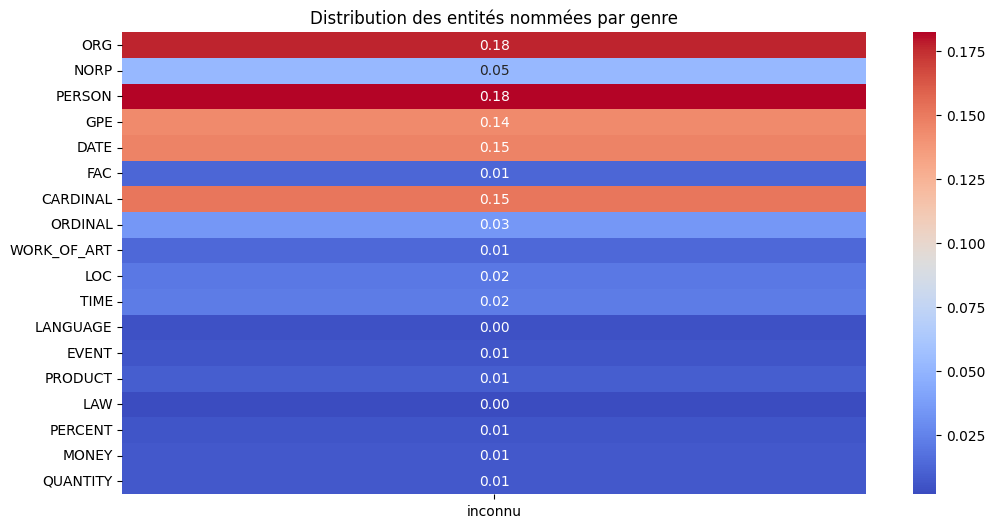


Significativité des différences entre genres (NER): p=1.0000


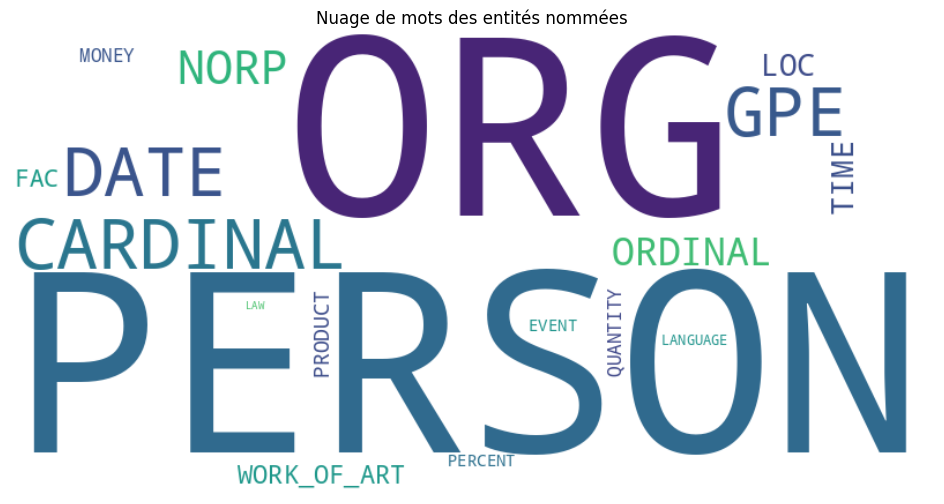

In [48]:
def extract_named_entities(sentences):
    ner_counter = Counter()
    ner_genre = defaultdict(Counter)

    for sent in sentences:
        genre = sent.metadata.get('genre', 'inconnu')
        text = " ".join([token['form'] for token in sent])
        doc = nlp(text)

        for ent in doc.ents:
            ner_counter[ent.label_] += 1
            ner_genre[genre][ent.label_] += 1

    return ner_counter, ner_genre

ner_counter, ner_genre = extract_named_entities(sentences)

# F20. Visualisation des fréquences des entités nommées
plt.figure(figsize=(12, 6))
sns.barplot(x=list(ner_counter.keys()), y=list(ner_counter.values()))
plt.title('Distribution des types d’entités nommées')
plt.xlabel('Type d’entité')
plt.ylabel('Fréquence')
plt.xticks(rotation=45)
plt.show()

# F21. Distribution des entités nommées par genre
df_ner = pd.DataFrame(ner_genre).fillna(0)
df_ner = df_ner.div(df_ner.sum(axis=0), axis=1)  # Normalisation par genre

plt.figure(figsize=(12, 6))
sns.heatmap(df_ner, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Distribution des entités nommées par genre')
plt.show()

# F22. Test statistique sur la répartition des entités nommées
data_ner = [list(ner_genre[g].values()) for g in ner_genre.keys()]
chi2_ner, p_ner, _, _ = chi2_contingency(data_ner)
print(f"\nSignificativité des différences entre genres (NER): p={p_ner:.4f}")

# F23. Nuage de mots des entités nommées
wordcloud_ner = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(ner_counter)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_ner, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots des entités nommées")
plt.show()


##Senetiment analysis


In [49]:
def extract_named_entities(sentences):
    ner_counter = Counter()
    ner_genre = defaultdict(Counter)

    for sent in sentences:
        genre = sent.metadata.get('genre', 'unknown')
        text = " ".join([token['form'] for token in sent])
        doc = nlp(text)

        for ent in doc.ents:
            ner_counter[ent.label_] += 1
            ner_genre[genre][ent.label_] += 1

    return ner_counter, ner_genre



In [54]:
pip install textblob

In [56]:
from textblob import TextBlob
def get_sentiment(sentences):
    sentiment_scores = []

    for sent in sentences:
        text = " ".join([token['form'] for token in sent])
        sentiment = TextBlob(text).sentiment.polarity  # Polarity score [-1,1]
        sentiment_scores.append(sentiment)

    return sentiment_scores

In [58]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
def compute_sentence_embeddings(sentences):
    embeddings = []

    for sent in sentences:
        text = " ".join([token['form'] for token in sent])
        doc = nlp(text)
        embeddings.append(doc.vector)

    return np.array(embeddings)

def visualize_embeddings(embeddings, method='tsne'):
    if method == 'tsne':
        reduced = TSNE(n_components=2, perplexity=30).fit_transform(embeddings)
    else:
        reduced = PCA(n_components=2).fit_transform(embeddings)

    plt.figure(figsize=(10, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.7)
    plt.title(f'Sentence Embeddings ({method.upper()})')
    plt.show()

def cluster_sentences(embeddings, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(embeddings)
    return clusters


In [59]:
def plot_sentiment_distribution(sentiment_scores):
    plt.figure(figsize=(10, 5))
    sns.histplot(sentiment_scores, bins=20, kde=True, color='blue')
    plt.title('Sentiment Score Distribution')
    plt.xlabel('Sentiment Polarity')
    plt.ylabel('Frequency')
    plt.show()

def plot_named_entity_distribution(ner_counter):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(ner_counter.keys()), y=list(ner_counter.values()))
    plt.title('Named Entity Distribution')
    plt.xlabel('Entity Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

def wordcloud_from_entities(ner_counter):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(ner_counter)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Named Entity Word Cloud")
    plt.show()

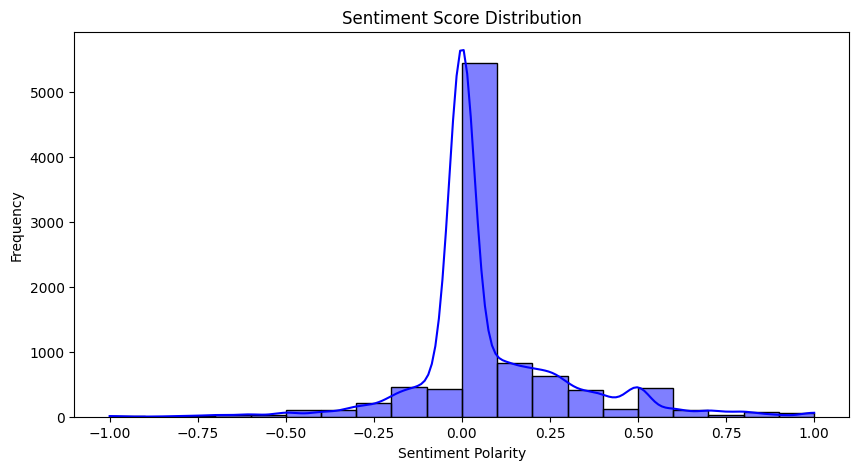

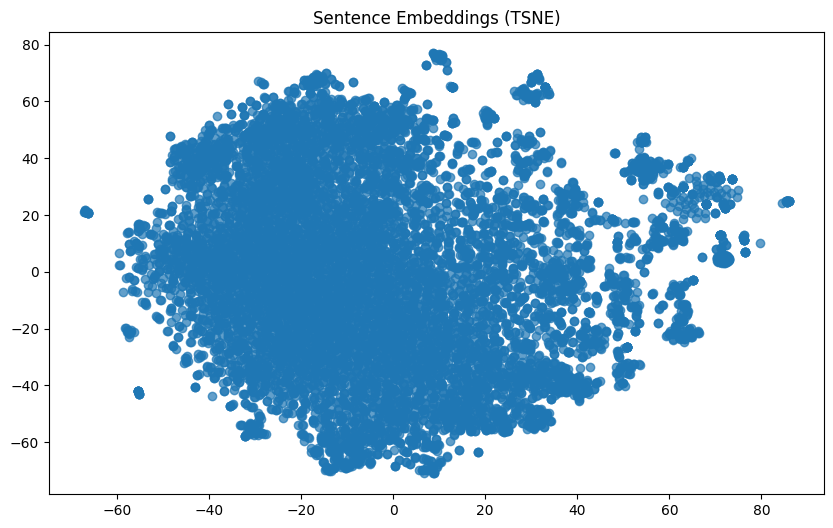

In [61]:
ner_counter, ner_genre = extract_named_entities(sentences)
sentiment_scores = get_sentiment(sentences)
embeddings = compute_sentence_embeddings(sentences)
clusters = cluster_sentences(embeddings)

# Visualization
plot_sentiment_distribution(sentiment_scores)
visualize_embeddings(embeddings, method='tsne')

In [63]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.5 MB/s eta 0:00:00


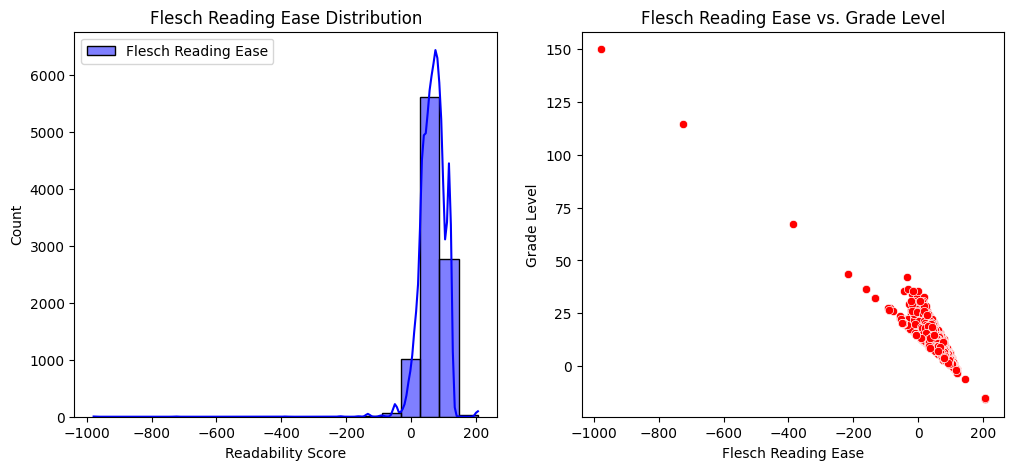

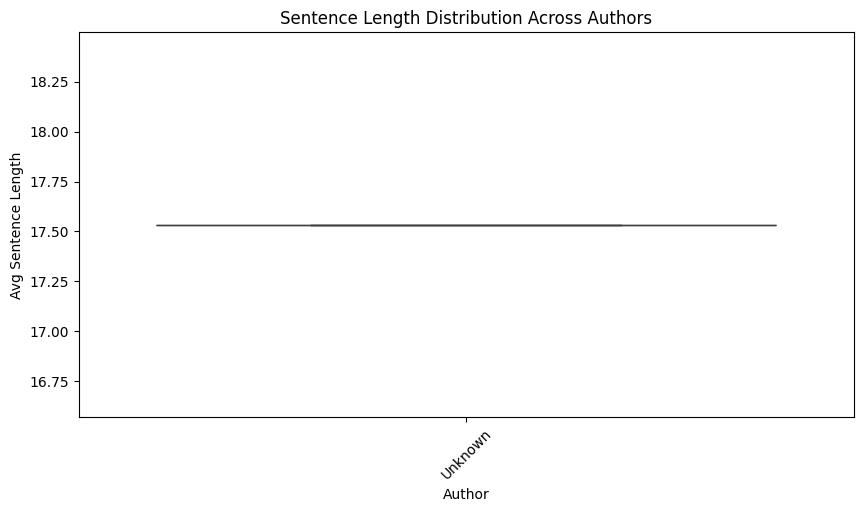

In [64]:
import textstat
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np

# --------------------------------------------
# 1️⃣ Compute Readability Scores
# --------------------------------------------

def compute_readability(sentences):
    scores = []
    for sent in sentences:
        text = " ".join([token['form'] for token in sent])
        flesch_reading_ease = textstat.flesch_reading_ease(text)
        flesch_grade_level = textstat.flesch_kincaid_grade(text)
        dale_chall = textstat.dale_chall_readability_score(text)
        scores.append((flesch_reading_ease, flesch_grade_level, dale_chall))

    return scores

# Compute readability scores
readability_scores = compute_readability(sentences)

# Convert to numpy array for easy processing
readability_scores = np.array(readability_scores)
flesch, grade, dale = readability_scores[:,0], readability_scores[:,1], readability_scores[:,2]

# Visualization - Readability Scores
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(flesch, bins=20, kde=True, color='blue', label="Flesch Reading Ease")
plt.xlabel("Readability Score")
plt.title("Flesch Reading Ease Distribution")
plt.legend()

plt.subplot(1,2,2)
sns.scatterplot(x=flesch, y=grade, color='red')
plt.xlabel("Flesch Reading Ease")
plt.ylabel("Grade Level")
plt.title("Flesch Reading Ease vs. Grade Level")
plt.show()

# --------------------------------------------
# 2️⃣ Author Identification via Stylometry
# --------------------------------------------

# Extract stylistic features per author
author_styles = defaultdict(lambda: {"word_length": [], "sentence_length": [], "pos_dist": defaultdict(int)})

for sent in sentences:
    author = sent.metadata.get("author", "Unknown")  # Extract author info
    words = [token['form'] for token in sent]
    pos_tags = [token['upostag'] for token in sent]

    author_styles[author]["word_length"].extend([len(word) for word in words])
    author_styles[author]["sentence_length"].append(len(words))

    for pos in pos_tags:
        author_styles[author]["pos_dist"][pos] += 1

# Convert to DataFrame for visualization
author_data = []
for author, features in author_styles.items():
    avg_word_length = np.mean(features["word_length"])
    avg_sentence_length = np.mean(features["sentence_length"])
    author_data.append({"Author": author, "Avg Word Length": avg_word_length, "Avg Sentence Length": avg_sentence_length})

df_author = pd.DataFrame(author_data)

# Visualization - Box Plot of Sentence Length Across Authors
plt.figure(figsize=(10,5))
sns.boxplot(x="Author", y="Avg Sentence Length", data=df_author)
plt.xticks(rotation=45)
plt.title("Sentence Length Distribution Across Authors")
plt.show()
